# Artificial Neural Network implementation using PyTorch

Importing additional libraries for neural network computing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn, Tensor
import torch.optim as optim
import torch.utils.data as data
import copy

### Loading the data

The task is the same as the multi-variable regression task carried out previously: estimating the Horsepower of each car based on the Engine size and Fuel efficiency.

In [2]:
df=pd.read_csv("DataANN/Car_sales.csv")
df['Engine_ccm'] = df['Engine_size'] * 1000
#'Horsepower', 'Engine_ccm', 'Fuel_efficiency', 'Price_in_thousands', 'Fuel_capacity'
df = df.dropna(subset=['Horsepower', 'Engine_ccm', 'Fuel_efficiency'])
X = df[['Engine_ccm','Fuel_efficiency']]
Y = df[['Horsepower']]
x = X.values
y = Y.values

### Preparing data

In this case, the data preparation only includes the division of the entire data set into teaching validation and test parts. The entire data set must describe reality well and all three parts must describe the entire data set well.

In [3]:
train_size = int(len(x) * 0.6)
valid_size = int(len(x) * 0.2)
test_size = len(x) - train_size - valid_size
x1=np.double(np.concatenate((np.ones(len(x)).reshape(-1,1), x), axis=1))
x_train, x_valid, x_test = torch.tensor(x1[:train_size]), torch.tensor(x1[train_size:train_size+valid_size]),torch.tensor(x1[train_size+valid_size:])
y_train, y_valid, y_test = torch.tensor(y[:train_size]), torch.tensor(y[train_size:train_size+valid_size]),torch.tensor(y[train_size+valid_size:])

### Create a Neural network with PyTorch

The Pytorch Neural Network (https://pytorch.org/docs/stable/nn.html) model class consists of two main parts:
* Initialization - contains the layers and submodels of the model
* Foward - contains the structure of the model

Parts of a simple MLP model:
* Linear layer - parameters: number of inputs and outputs 
* Activation layer

In [4]:
class CarANN(nn.Module):
    def __init__(self, num_input=3, num_output=1):
        super().__init__()
        self.linear1 = nn.Linear(num_input, 20)
        #self.act = nn.ReLU()
        self.act = nn.Sigmoid()
        self.linear2 = nn.Linear(20, num_output)
    def forward(self, x):
        x = self.linear1(x)
        x=self.act(x)
        x = self.linear2(x)
        return x

### Set up the model

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CarANN(num_input=3, num_output=1).double().to(device)

### Optimizers and their options

There are some pre-built optimizers in PyTorch (https://pytorch.org/docs/stable/optim.html), they are sufficient in most cases, especially if their parameters are well set. The two most well-known are ADAM and SGD, both of which originate from Gradient Descent, which we implemented earlier.

* **S**tochastic **G**radient **D**escent  - https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
* **ADA**ptive **M**oment optimizer - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
* A good general overview - https://www.ruder.io/optimizing-gradient-descent/

In [6]:
#optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9, dampening=0, weight_decay=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.99, 0.999), eps=1e-08, weight_decay=0.001)

### Loss functions and their options

Built-in cost/loss functions are also available in PyTorch (https://pytorch.org/docs/stable/nn.html#loss-functions). There are two main types: categorical and general.

For a regression task, we need a general, of which I would highlight the following 3:
* L1 norm (or absolute value) - https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
* Squared L2 norm (or mean squared error) - https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss
* Smoothed L1 norm - https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html#torch.nn.SmoothL1Loss


In [7]:
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss() #mean abs
#loss_fn = nn.SmoothL1Loss(reduction='mean', beta=1.0)

### Dataloder and its options

The DataLoader (https://pytorch.org/docs/stable/data.html) has 3 main parameters: 
* dataset - The dataset itself
* batch_size - Number of evaluations used for an optimization step
* shuffle - Regenerates batches in every epoch (cannot be used in the case of time series data)

In [8]:
batch_size=10
loader = data.DataLoader(data.TensorDataset(x_train, y_train), shuffle=True, batch_size=batch_size)

## Training

Training and testing a model always consists of 3 parts:
* Training - only the training data set is used, and the weights are updated based on this
* Validation - the validation data set is used, indirectly participates in training and serves to monitor the training process
* Testing - the test data set is used, it does not participate in training in any way, and the goal is independent testing and comparison


Training

In [9]:
n_epochs = 1000
hist_train=[];
hist_valid=[];
best_loss=float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_tolerant_count=0
early_stop_tolerant=10;
for epoch in range(n_epochs):
    # Training
    model.train()
    for X_batch, y_batch in loader:
        
        y_pred = model(X_batch.to(device))
        train_loss = loss_fn(y_pred, y_batch.to(device))
        train_loss=train_loss/batch_size
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss=0
        for i in range(0,valid_size-1):
            y_pred = model(x_valid[i].to(device))
            valid_loss = valid_loss+torch.sqrt(loss_fn(y_pred, y_valid[i].to(device)))
        valid_loss=valid_loss/valid_size                        
        hist_train.append(np.array(train_loss.cpu().detach()))
        hist_valid.append(np.array(valid_loss.cpu().detach()))
        
    # Always save the current best model based on the validation data, and stop the training if no improvements happen after a certain epoch.    
    early_stop_tolerant_count=early_stop_tolerant_count+1
    if valid_loss < best_loss:
        early_stop_tolerant_count=0
        best_loss = valid_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    if early_stop_tolerant_count>=early_stop_tolerant:
        break 
    if epoch % 50 != 0:
        continue       
    # Display some information along the training
    print("Epoch %.4d: train loss %.2f, valid loss %.2f" % (epoch, train_loss, valid_loss))
    
    
#Test    
model.load_state_dict(best_model_wts)
test_loss=0
for i in range(0,test_size-1):
    y_pred = model(x_test[i].to(device))
    test_loss = test_loss+torch.sqrt(loss_fn(y_pred, y_test[i].to(device)))
test_loss=test_loss/test_size

print("Final epoch %d: train loss %.2f, valid loss %.2f, test loss %.2f" % (epoch, train_loss, valid_loss, test_loss))

Epoch 0000: train loss 3820.03, valid loss 185.38
Epoch 0050: train loss 1873.21, valid loss 125.64
Epoch 0100: train loss 140.01, valid loss 71.18
Epoch 0150: train loss 681.69, valid loss 40.68
Epoch 0200: train loss 766.05, valid loss 33.96
Final epoch 216: train loss 230.61, valid loss 33.99, test loss 47.12


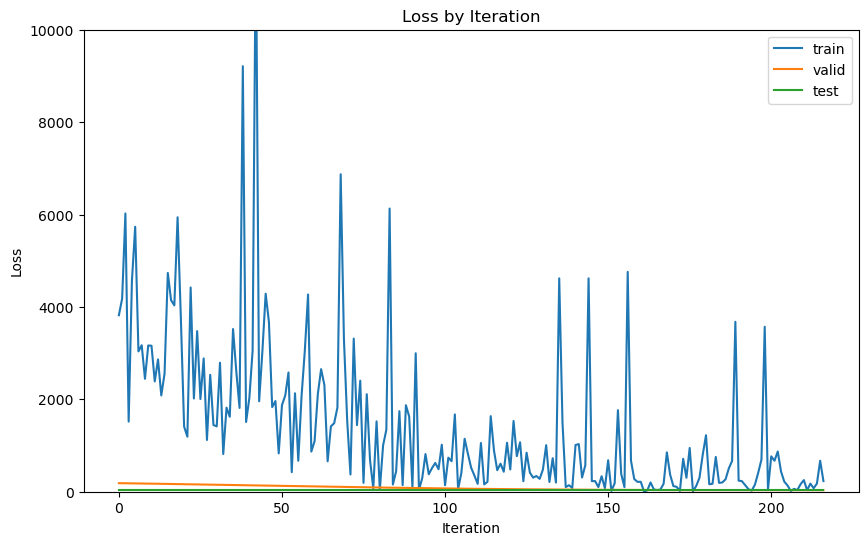

In [10]:
%matplotlib inline 
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss by Iteration')
plt.plot(hist_train)
plt.plot(hist_valid)
plt.plot(test_loss.cpu().detach().numpy()*np.ones(len(hist_valid)))
plt.ylim((0,10000))
plt.legend(['train', 'valid', 'test'])

Homework: Try different cost functions and other parameters. 

<div style="text-align: right">Created by Szilárd Kovács</div>